In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import glob
import torch
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as F
from tqdm.notebook import tqdm
import random
from PIL import Image
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [3]:
def ifnone(a,b):
    if a is None:
        return b
    else:
        return a
def transform(input, target,size=(512,1024)):
    input,target = F.resize(input,size),F.resize(target,size)
    a, t, sc, sh = transforms.RandomAffine.get_params(degrees=(0,0),
                                                      translate=(0.1,0.1),
                                                      scale_ranges=(2,2),
                                                      shears=(5,5),
                                                      img_size=size)
    input = F.affine(input, a, t, sc, sh)
    target = F.affine(target, a, t, sc, sh)
    if random.random() > 0.5:
        input = F.hflip(input)
        target = F.hflip(target)
    input,target = F.to_tensor(input), torch.Tensor(np.array(target))
    input = F.normalize(input,imagenet_stats[0],imagenet_stats[1])
    return input, target
def prep_mask(mask):
    return torch.Tensor(mask)
class CityscapesDataset(Dataset):
    def __init__(self,im_path,lab_path,transforms=True,label_func=None):
        self.files = glob.glob(im_path+'/*/*.png')
        self.label_func = lambda x: lab_path+'/'+'/'.join(x.split('/')[-3:])[:-15]+'gtFine_labelIds.png'
        self.label_files = [self.label_func(x) for x in self.files]
        self.transform = transforms
        self.c = 12
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        im = Image.open(self.files[i])
        mask = Image.open(self.label_files[i])
        if self.transform:
            im,mask = transform(im,mask)    
        else:
            im,mask = F.to_tensor(im),torch.tensor(np.array(mask))
            im = F.normalize(im,imagenet_stats[0],imagenet_stats[1])
        return {'im':im,'mask':mask.squeeze()}

In [4]:
train_data = CityscapesDataset('../leftImg8bit/train/','../gtFine')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


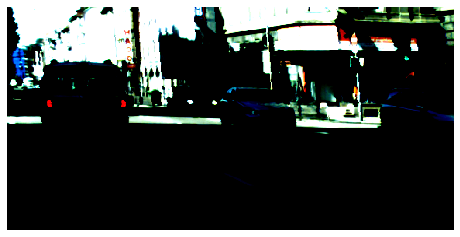

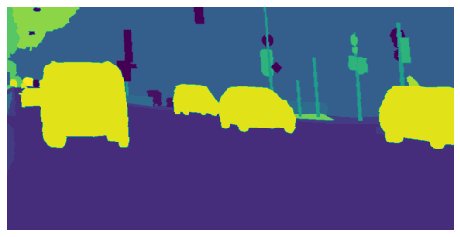

In [22]:
from fastai.vision import Image as Fimage
d = train_data[0]
Fimage(d['im']).show(figsize=(8,8))
Fimage(d['mask'].unsqueeze(0)).show(figsize=(8,8))

In [23]:
d['im'].shape

torch.Size([3, 512, 1024])

In [5]:
train_data = CityscapesDataset('../leftImg8bit/train/','../gtFine')
valid_data = CityscapesDataset('../leftImg8bit/val/','../gtFine')
test_data = CityscapesDataset('../leftImg8bit/test/','../gtFine')
train_dl = DataLoader(train_data,batch_size=10,shuffle=True)
valid_dl = DataLoader(valid_data,batch_size=10,shuffle=False)
test_dl = DataLoader(test_data,batch_size=10,shuffle=False)
from linknet_model import Linknet
model = Linknet(34)
class_weights = np.load('cls_wts_34.npy')
# train_data = CamvidCombDataset('../camvid','../SegNet-Tutorial/CamVid/train.txt')
# valid_data = CamvidCombDataset('../camvid','../SegNet-Tutorial/CamVid/val.txt', transforms=False)
# test_data = CamvidCombDataset('../camvid','../SegNet-Tutorial/CamVid/test.txt', transforms=False)
# train_dl = DataLoader(train_data,batch_size=8,shuffle=True)
# valid_dl = DataLoader(valid_data,batch_size=8,shuffle=False)
# test_dl = DataLoader(test_data,batch_size=8,shuffle=False)
# from linknet_model import Linknet
# model = Linknet(32)

In [6]:
len(train_data),len(valid_data),len(test_data)

(2975, 500, 1525)

In [7]:
import matplotlib.pyplot as plt
def dice(inp,targ):
    n = inp.shape[0]
    inp = inp.argmax(dim=1)
    dice = 0
#     Image(torch.abs(inp-targ)).show(figsize=(10,10))
#     diff = torch.abs(inp[0]-targ[0]).cpu().numpy()
#     diff = np.where(diff==0,0,1)
#     plt.figure(figsize=(5,5))
#     plt.imshow(diff,cmap='gray') 
#     plt.show()
    for i in range(n):
        imdice = 0
        for j in torch.unique(targ[i]):
            inpb = torch.where(inp[i]==j,torch.ones_like(inp).cuda(),torch.zeros_like(inp).cuda()).view(-1)
            targb = torch.where(targ[i]==j,torch.ones_like(targ).cuda(),torch.zeros_like(targ).cuda()).view(-1)
            intersection = 2*(inpb*targb).sum()
            union = (inpb+targb).sum()
            class_dice = (intersection/(union + 1e-8))
#             print(class_dice)
            imdice += class_dice
        imdice /= n*torch.unique(targ[i]).shape[0]
        dice += imdice
    return dice

In [ ]:
# @TODO: Aug and lr decay. Done
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
model.cuda()
opt = torch.optim.AdamW(model.parameters())
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=3e-4,div_factor=5,final_div_factor=10000,epochs=80,steps_per_epoch=298,pct_start=0.3)
best_dice = 0
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).cuda())
for epoch in tqdm(range(80)):
    model.train()
    for batch in train_dl:
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        loss = loss_fn(ypred,yb.long())
        print(f'{loss:.4f}', end='\r')
        loss.backward()
        opt.step()
        opt.zero_grad()
        sched.step()
    model.eval()
    d=0
    for i,batch in enumerate(valid_dl):
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        d += dice(ypred.detach(),yb).item()
    d /= i+1
    print(f'Epoch {epoch}: Train Loss: {loss:.4f}, Val Dice: {d:.4f}')
    if d>=best_dice:
        print(f'Better model found at epoch: {epoch}')
        torch.save(model.state_dict(),'best_dice_city.pkl')
        best_dice = d

Epoch 0: Train Loss: 3.0017, Val Dice: 0.0849
Better model found at epoch: 0
Epoch 1: Train Loss: 2.6677, Val Dice: 0.1214
Better model found at epoch: 1
Epoch 2: Train Loss: 2.3478, Val Dice: 0.1377
Better model found at epoch: 2
Epoch 3: Train Loss: 1.9948, Val Dice: 0.1605
Better model found at epoch: 3
Epoch 4: Train Loss: 1.8441, Val Dice: 0.1786
Better model found at epoch: 4
Epoch 5: Train Loss: 1.8266, Val Dice: 0.1854
Better model found at epoch: 5
Epoch 6: Train Loss: 1.9798, Val Dice: 0.1949
Better model found at epoch: 6
Epoch 7: Train Loss: 1.9502, Val Dice: 0.2007
Better model found at epoch: 7
Epoch 8: Train Loss: 1.8394, Val Dice: 0.2050
Better model found at epoch: 8
Epoch 9: Train Loss: 1.4129, Val Dice: 0.2178
Better model found at epoch: 9
Epoch 10: Train Loss: 1.2797, Val Dice: 0.2181
Better model found at epoch: 10
Epoch 11: Train Loss: 1.4076, Val Dice: 0.2220
Better model found at epoch: 11
Epoch 12: Train Loss: 1.3081, Val Dice: 0.2273
Better model found at epo

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [7]:
# @TODO: Aug and lr decay
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
model.cuda()
opt = torch.optim.AdamW(model.parameters())
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=3e-3,div_factor=5,final_div_factor=10000,epochs=100,steps_per_epoch=46,pct_start=0.3)
best_dice = 0
for epoch in tqdm(range(100)):
    model.train()
    for batch in train_dl:
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        loss = nn.CrossEntropyLoss(weights=torch.Tensor(class_weights))(ypred,yb.long())
        print(f'{loss:.4f}', end='\r')
        loss.backward()
        opt.step()
        opt.zero_grad()
        sched.step()
    model.eval()
    d=0
    for i,batch in enumerate(valid_dl):
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        d += dice(ypred.detach(),yb).item()
    d /= i+1
    print(f'Epoch {epoch}: Train Loss: {loss:.4f}, Val Dice: {d:.4f}')
    if d>=best_dice:
        print(f'Better model found at epoch: {epoch}')
        torch.save(model.state_dict(),'best_dice.pkl')
        best_dice = d

Epoch 0: Train Loss: 2.3039, Val Dice: 0.1334
Better model found at epoch: 0
Epoch 1: Train Loss: 1.8418, Val Dice: 0.1408
Better model found at epoch: 1
Epoch 2: Train Loss: 1.4038, Val Dice: 0.1863
Better model found at epoch: 2
Epoch 3: Train Loss: 1.2527, Val Dice: 0.1941
Better model found at epoch: 3
Epoch 4: Train Loss: 1.0316, Val Dice: 0.1919
Epoch 5: Train Loss: 1.0337, Val Dice: 0.2075
Better model found at epoch: 5
Epoch 6: Train Loss: 0.9947, Val Dice: 0.2419
Better model found at epoch: 6
Epoch 7: Train Loss: 0.8950, Val Dice: 0.2579
Better model found at epoch: 7
Epoch 8: Train Loss: 0.7120, Val Dice: 0.2450
Epoch 9: Train Loss: 0.9295, Val Dice: 0.2460
Epoch 10: Train Loss: 0.7792, Val Dice: 0.1721
Epoch 11: Train Loss: 1.0130, Val Dice: 0.2795
Better model found at epoch: 11
Epoch 12: Train Loss: 0.7067, Val Dice: 0.2360
Epoch 13: Train Loss: 0.5624, Val Dice: 0.2915
Better model found at epoch: 13
Epoch 14: Train Loss: 0.5369, Val Dice: 0.2974
Better model found at ep

In [7]:
# @TODO: Aug and lr decay
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
model.cuda()
opt = torch.optim.Adam(model.parameters())
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=3e-3,div_factor=5,final_div_factor=10000,epochs=50,steps_per_epoch=46,pct_start=0.3)
best_dice = 0
for epoch in tqdm(range(50)):
    model.train()
    for batch in train_dl:
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        loss = nn.CrossEntropyLoss()(ypred,yb.long())
        print(f'{loss:.4f}', end='\r')
        loss.backward()
        opt.step()
        opt.zero_grad()
#         sched.step()
    model.eval()
    d=0
    for i,batch in enumerate(valid_dl):
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        d += dice(ypred.detach(),yb).item()
    d /= i+1
    print(f'Epoch {epoch}: Train Loss: {loss:.4f}, Val Dice: {d:.4f}')
    if d>=best_dice:
        print(f'Better model found at epoch: {epoch}')
        torch.save(model.state_dict(),'best_dice.pkl')
        best_dice = d

Epoch 0: Train Loss: 2.3470, Val Dice: 0.1563
Better model found at epoch: 0
Epoch 1: Train Loss: 1.6081, Val Dice: 0.1798
Better model found at epoch: 1
Epoch 2: Train Loss: 1.2108, Val Dice: 0.1907
Better model found at epoch: 2
Epoch 3: Train Loss: 1.1284, Val Dice: 0.1921
Better model found at epoch: 3
Epoch 4: Train Loss: 1.0706, Val Dice: 0.2005
Better model found at epoch: 4
Epoch 5: Train Loss: 0.8024, Val Dice: 0.2133
Better model found at epoch: 5
Epoch 6: Train Loss: 1.0927, Val Dice: 0.2189
Better model found at epoch: 6
Epoch 7: Train Loss: 0.7545, Val Dice: 0.2539
Better model found at epoch: 7
Epoch 8: Train Loss: 0.9478, Val Dice: 0.2350
Epoch 9: Train Loss: 0.6668, Val Dice: 0.2539
Better model found at epoch: 9
Epoch 10: Train Loss: 0.7423, Val Dice: 0.2635
Better model found at epoch: 10
Epoch 11: Train Loss: 0.7169, Val Dice: 0.2741
Better model found at epoch: 11
Epoch 12: Train Loss: 0.6852, Val Dice: 0.2803
Better model found at epoch: 12
Epoch 13: Train Loss: 0.

# crap

In [39]:
def gen_cls_wts(train_dl,n):
    class_counts = [0]*n
    for batch in tqdm(train_dl):
        unique,counts = np.unique(batch['mask'],return_counts=True)
        for i,u in enumerate(unique):
            class_counts[int(u.item())] += counts[i]

    class_counts = np.array(class_counts)/sum(class_counts)
    print(class_counts)
    class_weights = 1/np.log(1.02 + class_counts)
    print(class_weights)
    np.save(f'cls_wts_{n}.npy',class_weights)

In [36]:
u = []
for i,batch in enumerate(tqdm(train_dl)):
    unique = np.unique(batch['mask']).tolist()
    u.extend(unique)
    u = list(set(u))
    if i==100: break

In [40]:
gen_cls_wts(train_dl,35)


[2.877115e-05 9.315465e-04 4.751831e-05 2.335428e-05 1.330755e-02 3.913187e-03 1.400294e-02 4.352261e-01 5.121868e-02
 6.795434e-03 3.728245e-03 1.472686e-01 9.267552e-03 1.002639e-02 2.391407e-03 4.099992e-03 4.066774e-03 1.025955e-02
 2.693643e-03 3.970286e-03 7.378654e-03 1.164200e-01 1.184991e-02 1.046468e-02 2.078858e-02 3.674760e-03 8.730928e-02
 3.695242e-03 3.935640e-03 6.565966e-04 4.924909e-04 3.526185e-03 1.445005e-03 5.095398e-03 0.000000e+00]
[50.426523 48.273052 50.379832 50.44003  30.520491 42.315962 29.906433  2.66552  14.535527 37.817588 42.641912
  6.465523 34.665127 33.801574 45.158143 41.991805 42.04908  33.544931 44.563334 42.216343 37.022555  7.81965
 31.894651 33.322398 25.013336 42.737127  9.810365 42.700614 42.276732 48.908982 49.296672 43.003891 47.129136
 40.345878 50.49835 ]


In [41]:
arr = np.load('cls_wts_35.npy')

In [44]:
np.save('cls_wts_34.npy',arr[:-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['../camvid/images/0001TP_006690.png', '../camvid/images/0001TP_006720.png', '../camvid/images/0001TP_006750.png', '../camvid/images/0001TP_006780.png', '../camvid/images/0001TP_006810.png']
['../camvid/images/0001TP_006690.png', '../camvid/images/0001TP_006720.png', '../camvid/images/0001TP_006750.png', '../camvid/images/0001TP_006780.png', '../camvid/images/0001TP_006810.png']


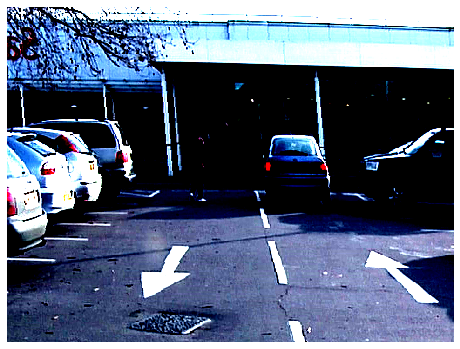

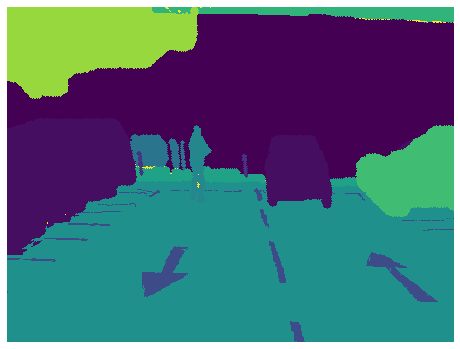

In [27]:
data = CamvidCombDataset('../camvid','../SegNet-Tutorial/CamVid/train.txt')
from fastai.vision import Image as Fimage
d = data[0]
Fimage(d['im']).show(figsize=(8,8))
Fimage(d['mask'].unsqueeze(0)).show(figsize=(8,8))

In [4]:
data = CamvidDataset('../camvid',train=False)
from fastai.vision import Image as Fimage
d = data[0]
# Fimage(d['im']).show(figsize=(8,8))
# Fimage(d['mask'].unsqueeze(0)).show(figsize=(8,8))

In [7]:
# train
len(data)

600

In [9]:
# valid
len(data)

101

In [16]:
# 360,480 -> 576,768
train_data[0]['mask'].shape

torch.Size([360, 480])

In [7]:
torch.save(model.state_dict(),'20ep-aug.pkl')

In [5]:
# @TODO: Aug and lr decay
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
model.cuda()
opt = torch.optim.Adam(model.parameters())
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=3e-3,div_factor=5,final_div_factor=10000,epochs=60,steps_per_epoch=800,pct_start=0.1)
for epoch in tqdm(range(70)):
    for batch in train_dl:
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        loss = nn.CrossEntropyLoss()(ypred,yb.long())
        print(f'{loss:.4f}', end='\r')
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(f'Epoch {epoch}: Train Loss: {loss:.4f}')

Epoch 0: Train Loss: 1.1453
Epoch 1: Train Loss: 0.8761
Epoch 2: Train Loss: 0.5153
Epoch 3: Train Loss: 0.4587
Epoch 4: Train Loss: 0.4789
Epoch 5: Train Loss: 0.4219
Epoch 6: Train Loss: 0.3838
Epoch 7: Train Loss: 0.3810
Epoch 8: Train Loss: 0.3326
Epoch 9: Train Loss: 0.3161
Epoch 10: Train Loss: 0.4060
Epoch 11: Train Loss: 0.3802
Epoch 12: Train Loss: 0.4160
Epoch 13: Train Loss: 0.2975
Epoch 14: Train Loss: 0.2700
Epoch 15: Train Loss: 0.3695
Epoch 16: Train Loss: 0.3791
Epoch 17: Train Loss: 0.3064
Epoch 18: Train Loss: 0.3113
Epoch 19: Train Loss: 0.3248
Epoch 20: Train Loss: 0.3021
Epoch 21: Train Loss: 0.3248
Epoch 22: Train Loss: 0.2433
Epoch 23: Train Loss: 0.3544
Epoch 24: Train Loss: 0.3139
Epoch 25: Train Loss: 0.2983
Epoch 26: Train Loss: 0.2786
Epoch 27: Train Loss: 0.2471
Epoch 28: Train Loss: 0.2564
Epoch 29: Train Loss: 0.2886
Epoch 30: Train Loss: 0.2327
Epoch 31: Train Loss: 0.1937
Epoch 32: Train Loss: 0.2143
Epoch 33: Train Loss: 0.2197
Epoch 34: Train Loss: 0.

In [6]:
torch.save(model.state_dict(),'70ep-no-aug.pkl')

In [12]:
model.load_state_dict(torch.load('best_dice.pkl'))

<All keys matched successfully>

In [11]:
# should hit 68.3
model.eval()
model.cuda()
d=0
for i,batch in enumerate(tqdm(valid_dl)):
    ypred = model(batch['im'].cuda())
    yb = batch['mask'].cuda()
    d += dice(ypred.detach(),yb).item()
print(d/(i+1))


0.2848660400509834


In [8]:
# should hit 68.3
model.eval()
d=0
for i,batch in enumerate(tqdm(test_dl)):
    ypred = model(batch['im'].cuda())
    yb = batch['mask'].cuda()
    d += dice(ypred.detach(),yb).item()
print(d/(i+1))


0.5877080778280894



0.6395981449347276


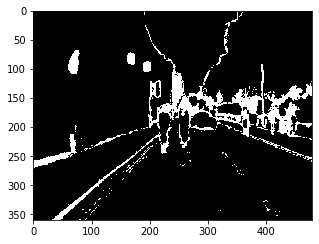

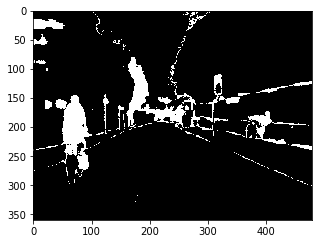

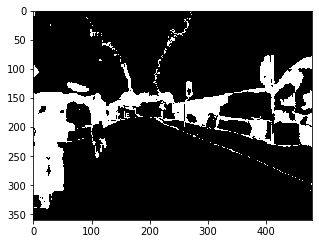

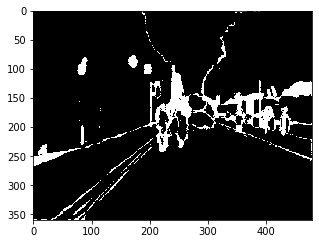

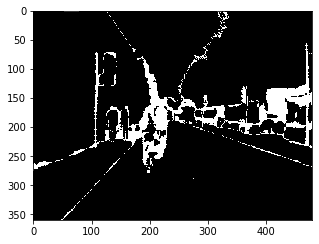

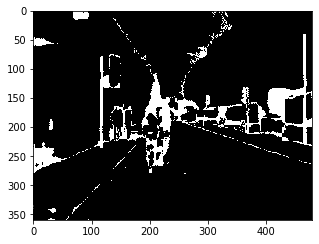

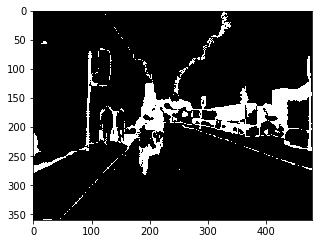

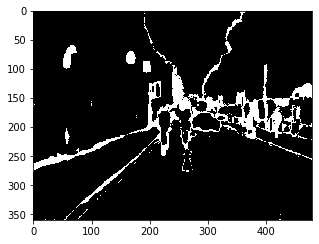

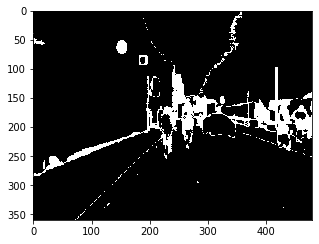

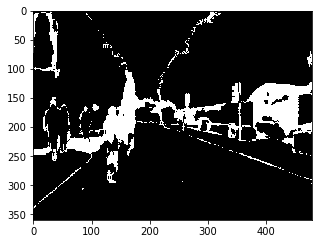

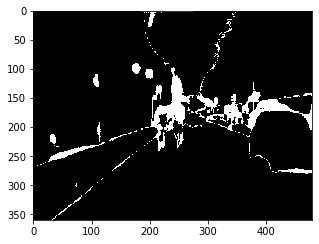

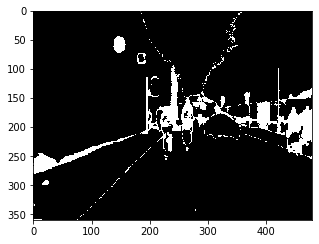

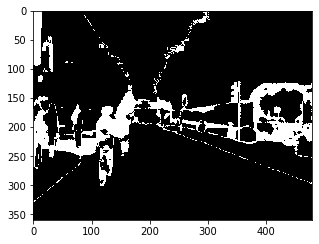

In [11]:
model.eval()
d=0
for i,batch in enumerate(tqdm(valid_dl)):
    ypred = model(batch['im'].cuda())
    yb = batch['mask'].cuda()
    d += dice(ypred.detach(),yb).item()
print(d/(i+1))

# Inference

In [53]:
model.eval().cuda()
op = nn.LogSoftmax(dim=1)(model(valid_data[0]['im'].unsqueeze(0).cuda()))
op = op.argmax(dim=1)

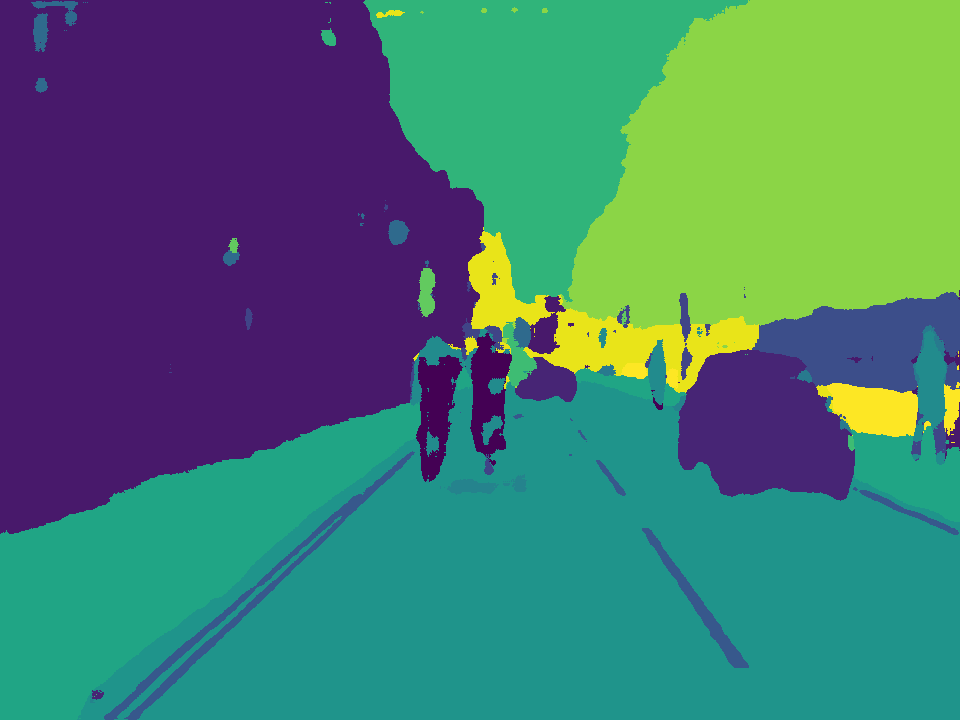

In [54]:
from fastai.vision import Image
Image(op.detach())

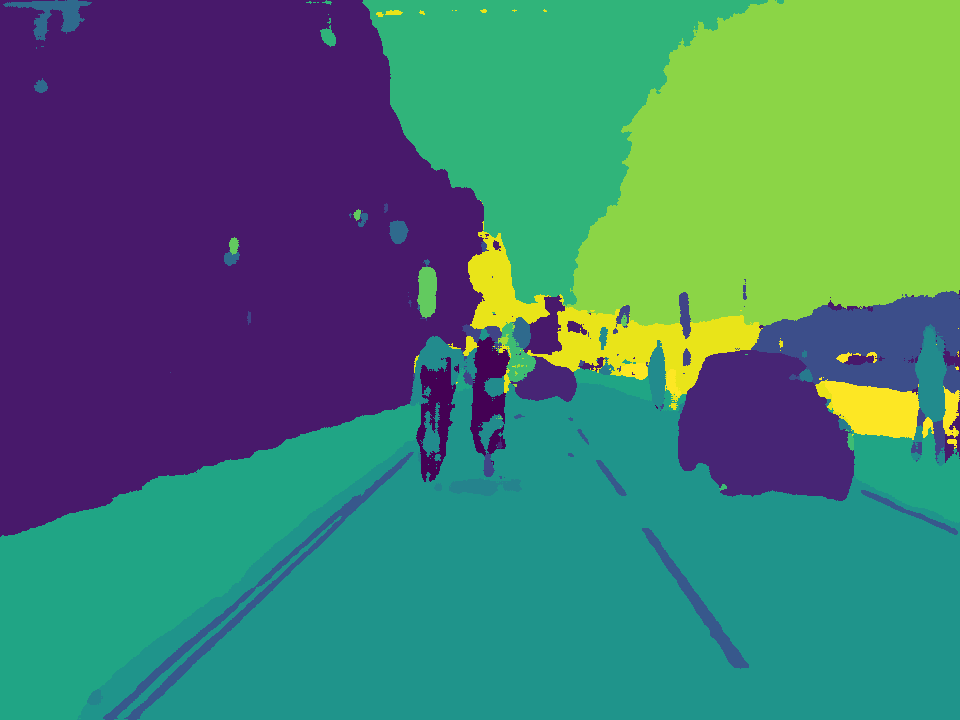

In [9]:
from fastai.vision import Image
Image(op.detach())

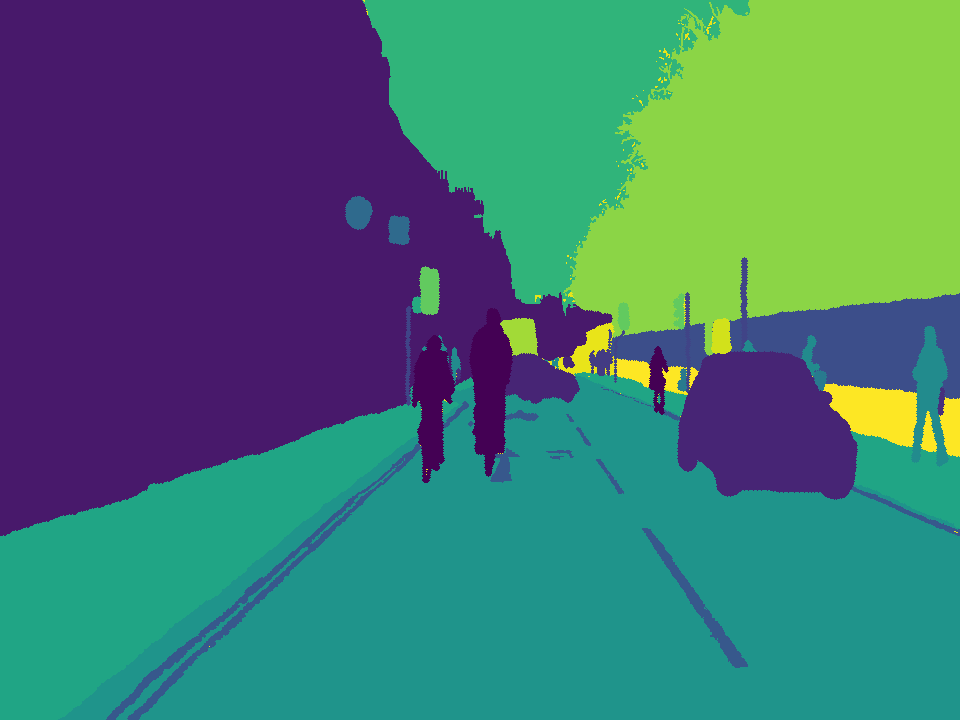

In [10]:
Image(valid_data[0]['mask'].unsqueeze(0))

In [7]:
torch.save(model.state_dict(),'30ep-no-aug.pkl')

In [51]:
d = torch.load('30ep-no-aug.pkl')
model.load_state_dict(d)

<All keys matched successfully>

In [12]:
op = nn.LogSoftmax(dim=1)(model(test_data[0]['im'].unsqueeze(0).cuda()))
op = op.argmax(dim=1)

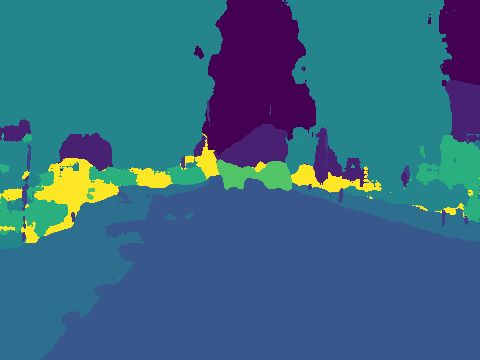

In [14]:
from fastai.vision import Image
Image(op.detach())

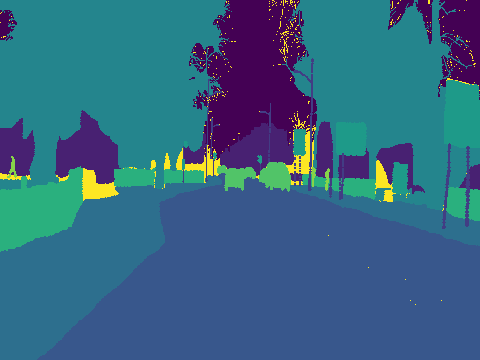

In [15]:
Image(test_data[0]['mask'].unsqueeze(0))

In [9]:
model.eval()
op = nn.LogSoftmax(dim=1)(model(test_data[0]['im'].unsqueeze(0).cuda()))
op = op.argmax(dim=1)

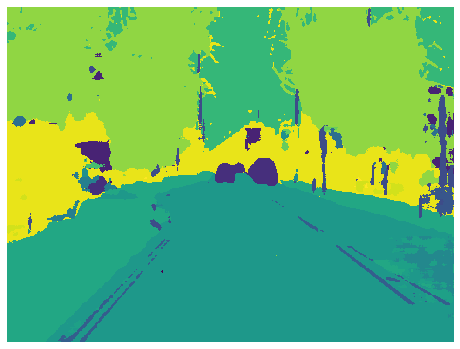

In [10]:
from fastai.vision import Image as Fimage
Fimage(op.detach()).show(figsize=(8,8))

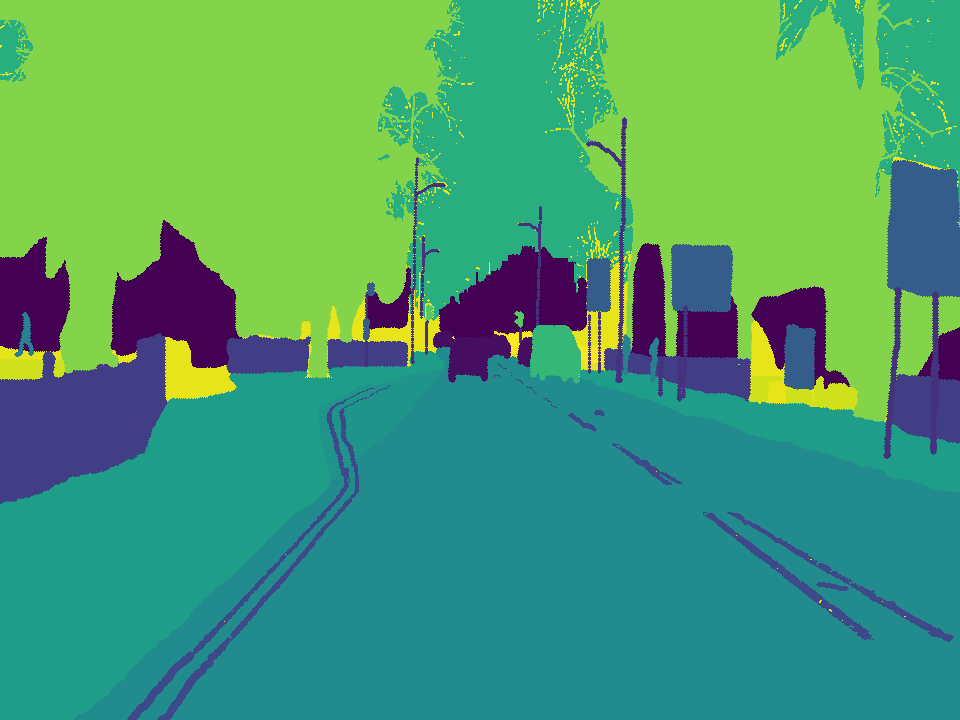

In [12]:
Fimage(test_data[0]['mask'].unsqueeze(0)).sow

# Camvid new

In [100]:
masks = glob.glob('../SegNet-Tutorial/CamVid/testannot/*.png')
u = []
for mask in masks:
    mask = io.imread(mask)
    u.extend(np.unique(mask).tolist())
    u = list(set(u))

In [102]:
len(masks)

233

In [103]:
len(glob.glob('../SegNet-Tutorial/CamVid/trainannot/*.png'))

367

In [105]:
len(glob.glob('../SegNet-Tutorial/CamVid/valannot/*.png'))

101